In [1]:
import os
import ee
import geopandas as gpd
import numpy as np

import rasterio
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from skimage.transform import resize
from skimage.exposure import rescale_intensity

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm

from rasterio.plot import reshape_as_image

In [2]:
from src.data.fetch import s2_from_gee, dynamic_world_from_gee, colorize_dynamic_world

In [3]:
SERVICE_ACCOUNT = "forest-mapping@forest-mapping.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(SERVICE_ACCOUNT, "../forest-mapping-gee.json")
ee.Initialize(credentials)

In [4]:
tiles = gpd.read_file('../data/interim/oregon_quarter_quads.shp')
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7508 entries, 0 to 7507
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CELL_ID     7508 non-null   int64   
 1   CELL_NAME   7508 non-null   object  
 2   PRIMARY_ST  7508 non-null   object  
 3   CELL_MAPCO  7508 non-null   object  
 4   CELL_TYPE   7508 non-null   int64   
 5   CELL_ALLWA  7508 non-null   int64   
 6   CELL_DESCR  0 non-null      object  
 7   CELL_DIACR  0 non-null      object  
 8   GLOBALID    7508 non-null   object  
 9   SHAPE_Leng  7508 non-null   float64 
 10  SHAPE_Area  7508 non-null   float64 
 11  geometry    7508 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 704.0+ KB


## An Illustrative Example
For a single tile, fetch the SENTINEL-2, LandTrendr, DEM, and NLCD imagery and plot it.

In [5]:
tile = tiles.sample(1)
bbox = tile.iloc[0]['geometry'].bounds
epsg = tiles.crs.to_epsg()
tile.iloc[0]

CELL_ID                                                  160188
CELL_NAME                                        Fanno Ridge SE
PRIMARY_ST                                               Oregon
CELL_MAPCO                                             44123-G5
CELL_TYPE                                                     1
CELL_ALLWA                                                    2
CELL_DESCR                                                 None
CELL_DIACR                                                 None
GLOBALID                 {B556C0F5-D397-11DE-9C20-00144F233E68}
SHAPE_Leng                                                 0.25
SHAPE_Area                                             0.003906
geometry      POLYGON ((533246.2026905792 1107745.3899671743...
Name: 7014, dtype: object

In [6]:
%%time
dw_ras, dw_profile = dynamic_world_from_gee(bbox, 2021, epsg)

CPU times: user 50.9 ms, sys: 0 ns, total: 50.9 ms
Wall time: 8.67 s


In [7]:
%%time
s2_ras, s2_profile = s2_from_gee(bbox, 2021, epsg)

CPU times: user 272 ms, sys: 36.4 ms, total: 308 ms
Wall time: 1min 19s


In [8]:
s2_rgb = reshape_as_image(np.clip(s2_ras[[12,11,10],:,:], 0, 3000)/3000.)

In [9]:
DW_COLOR_MAP = {
    "water": [65, 155, 223],  #419BDF, water
    "trees": [57, 125, 73],  # 397D49, trees
    "grass": [136, 176, 83],  # 88B053, grass
    "flooded vegetation": [122, 135, 198],  # 7A87C6, flooded_vegetation
    "crops": [228, 150, 53],  # E49635, crops
    "shrub and scrub": [223, 195, 90],  # DFC35A, shrub_and_scrub
    "built": [196, 40, 27],  # C4281B, built
    "bare": [165, 155, 143],  # A59B8F, bare
    "snow and ice": [179, 159, 225],  # B39FE1, snow_and_ice
}

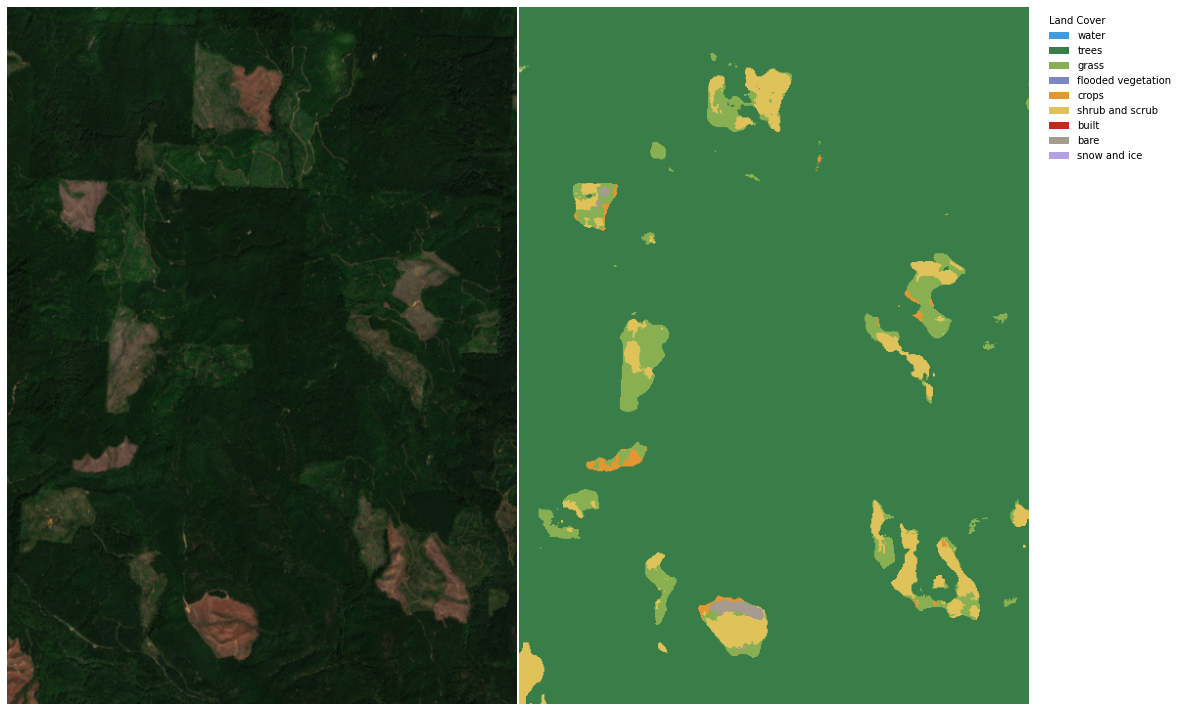

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16,10))
axs[0].imshow(s2_rgb)
axs[1].imshow(colorize_dynamic_world(dw_ras))

legend_elements = [
    Patch(facecolor=np.array(color)/255., edgecolor='none',
          label=landcover) for landcover, color in DW_COLOR_MAP.items()
]

leg = axs[1].legend(
    handles=legend_elements, 
    bbox_to_anchor=[1.30, 1.00], 
    edgecolor="none", 
    facecolor="none", 
    title="Land Cover"
)
leg._legend_box.align = "left"
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

## Download Data for Tiles in Oregon
With a helper function to download images, we'll iterate through all the tiles and fetch the data with some parallel processing.

In [11]:
def download_images(gdf_row, out_dir='../data/interim/oregon_imagery', 
                    overwrite=False, epsg=2992, year=2021):
    bbox = gdf_row['geometry'].bounds
    cell_id = gdf_row['CELL_ID']
    
    # get dynamic world and save to disk
    outfile = os.path.join(out_dir, 'dynamic_world', f'{cell_id}_dynamicworld{year}.tif')
    try:
        if not os.path.exists(outfile) or overwrite:
            ras, profile = dynamic_world_from_gee(bbox, year, epsg, scale=10)
            profile.update(compress='LZW')

            with rasterio.open(outfile, 'w', **profile) as dst:
                dst.write(ras, 1)
                dst.write_colormap(
                    1, {
                        0: [65, 155, 223],  #419BDF, water
                        1: [57, 125, 73],  # 397D49, trees
                        2: [136, 176, 83],  # 88B053, grass
                        3: [122, 135, 198],  # 7A87C6, flooded_vegetation
                        4: [228, 150, 53],  # E49635, crops
                        5: [223, 195, 90],  # DFC35A, shrub_and_scrub
                        6: [196, 40, 27],  # C4281B, built
                        7: [165, 155, 143],  # A59B8F, bare
                        8: [179, 159, 225],  # B39FE1, snow_and_ice
                    }
                )
    except Exception as e:
        print('Failed on', cell_id, e)
        return cell_id

In [12]:
to_run = [row for _, row in tiles[['geometry', 'CELL_ID']].iterrows()]
to_run[0]['CELL_ID']

221801

In [13]:
OUT_DIR = '../data/interim/oregon_imagery'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'dynamic_world'), exist_ok=True)

In [14]:
with ProcessPoolExecutor(32) as executor:
    completed = []
    jobs = [executor.submit(download_images, row, year=2021) for row in to_run]
    
    for job in tqdm(as_completed(jobs), total=len(jobs)):
        completed.append(job.result())   

  0%|          | 0/7508 [00:00<?, ?it/s]

In [15]:
with ProcessPoolExecutor(32) as executor:
    completed = []
    jobs = [executor.submit(download_images, row, year=2022) for row in to_run]
    
    for job in tqdm(as_completed(jobs), total=len(jobs)):
        completed.append(job.result())

  0%|          | 0/7508 [00:00<?, ?it/s]